In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from scipy.stats import entropy, f_oneway
from tqdm.notebook import tqdm

# =============================================================================
# --- 1. CORE OAFA SIMULATION DEFINITIONS ---
# =============================================================================

class Bird:
    """
    Represents a single bird agent in the flocking simulation, extended for OAFA.
    Includes adaptive rule weights and history for local entropy calculation.
    """
    def __init__(self, pos, vel, speed,
                 # OAFA specific additions
                 w_cohere_init, w_separation_init, w_alignment_init,
                 local_entropy_history_length=10):
        self.pos = np.array(pos, dtype=float)
        self.vel = np.array(vel, dtype=float)
        norm_vel = np.linalg.norm(self.vel)
        self.vel = self.vel / norm_vel if norm_vel > 0 else np.array([1.0, 0.0])
        self.speed = speed
        
        # Base Boids factors (will be modulated by adaptive weights)
        self.cohere_factor = 0.4
        self.separation_dist = 4.0
        self.separate_factor = 0.25
        self.match_factor = 0.02
        self.visual_distance = 5.0
        
        # OAFA: Adaptive Rule Weights (agent-specific)
        self.w_cohere = w_cohere_init
        self.w_separation = w_separation_init
        self.w_alignment = w_alignment_init

        # OAFA: History for local directional entropy calculation
        self.velocity_history = deque(maxlen=local_entropy_history_length)
        self.prev_local_entropy = 0.0

class Predator:
    """Represents a predator agent."""
    def __init__(self, pos, speed, extent, rng):
        self.pos = np.array(pos, dtype=float)
        self.vel = rng.uniform(-1, 1, size=2)
        self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])
        self.speed = speed
        self.extent = extent
        self.rng = rng

    def move(self):
        """Moves the predator and applies periodic boundary conditions."""
        self.pos += self.vel * self.speed
        self.pos %= self.extent
        # Predator randomly alters course
        if self.rng.random() < 0.1:
            angle_change = self.rng.uniform(-np.pi/4, np.pi/4)
            rotation_matrix = np.array([[np.cos(angle_change), -np.sin(angle_change)],
                                        [np.sin(angle_change),  np.cos(angle_change)]])
            self.vel = np.dot(self.vel, rotation_matrix)
            self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])

class OAFAModel:
    """Manages the OAFA simulation environment, agents, and predators."""
    def __init__(self, n_birds=100, num_predators=0, extent=50.0, seed=None):
        self.rng = np.random.default_rng(seed)
        self.extent = extent
        self.dt = 1.0 # Timestep duration
        
        # OAFA parameters
        self.oafa_learning_rate_eta = 0.01
        self.oafa_stochastic_epsilon_range = 0.1
        self.predator_detection_radius = 15.0

        # Initialize birds
        self.agents = [
            Bird(
                pos=self.rng.uniform(0, extent, 2),
                vel=self.rng.uniform(-1, 1, 2),
                speed=2.0,
                w_cohere_init=self.rng.uniform(0.4, 0.6),
                w_separation_init=self.rng.uniform(0.9, 1.1),
                w_alignment_init=self.rng.uniform(0.4, 0.6)
            ) for _ in range(n_birds)
        ]
        
        # Initialize predators
        self.predators = [
            Predator(
                pos=self.rng.uniform(0, extent, 2),
                speed=2.5,
                extent=extent,
                rng=self.rng
            ) for _ in range(num_predators)
        ]

def calculate_directional_entropy(velocities, num_bins=8):
    """Calculates the Shannon entropy of velocity directions."""
    if len(velocities) < 2: return 0.0
    non_zero_vels = velocities[np.linalg.norm(velocities, axis=1) > 1e-9]
    if len(non_zero_vels) < 2: return 0.0
    angles = (np.arctan2(non_zero_vels[:, 1], non_zero_vels[:, 0]) + 2 * np.pi) % (2 * np.pi)
    counts, _ = np.histogram(angles, bins=num_bins, range=(0, 2 * np.pi))
    return entropy(counts[counts > 0] / np.sum(counts))

def agent_step(agent, model):
    """Updates an agent's state using OAFA logic."""
    neighbors = [other for other in model.agents if other is not agent 
                 and np.linalg.norm(agent.pos - other.pos) < agent.visual_distance]

    # Calculate Boids and predator avoidance forces
    cohere_force, separate_force, match_force, predator_force = np.zeros(2), np.zeros(2), np.zeros(2), np.zeros(2)
    if neighbors:
        cohere_force = np.mean([n.pos for n in neighbors], axis=0) - agent.pos
        separate_force = sum(agent.pos - n.pos for n in neighbors if np.linalg.norm(agent.pos - n.pos) < agent.separation_dist)
        match_force = np.mean([n.vel for n in neighbors], axis=0) - agent.vel
    for predator in model.predators:
        vec_to_pred = agent.pos - predator.pos
        if np.linalg.norm(vec_to_pred) < model.predator_detection_radius:
            predator_force += vec_to_pred / (np.linalg.norm(vec_to_pred)**2 + 1e-9)

    # Apply adaptive weights from OAFA
    agent.vel += (cohere_force * agent.w_cohere * agent.cohere_factor +
                  separate_force * agent.w_separation * agent.separate_factor +
                  match_force * agent.w_alignment * agent.match_factor +
                  predator_force * 5.0) # Predator avoidance has a high, fixed weight
    
    # Normalize velocity and update position
    norm = np.linalg.norm(agent.vel)
    if norm > 0: agent.vel = (agent.vel / norm)
    agent.pos = (agent.pos + agent.vel * agent.speed * model.dt) % model.extent
    
    # --- OAFA Adaptation Step ---
    agent.velocity_history.append(agent.vel)
    current_local_entropy = calculate_directional_entropy(np.array(list(agent.velocity_history)))
    
    # Adapt weights to minimize local entropy (simplified gradient descent with noise)
    gradient_approx = current_local_entropy - agent.prev_local_entropy
    noise = model.rng.uniform(-model.oafa_stochastic_epsilon_range, model.oafa_stochastic_epsilon_range, 3)
    
    agent.w_cohere = np.clip(agent.w_cohere - model.oafa_learning_rate_eta * (gradient_approx + noise[0]), 0.1, 2.0)
    agent.w_separation = np.clip(agent.w_separation - model.oafa_learning_rate_eta * (gradient_approx + noise[1]), 0.1, 2.0)
    agent.w_alignment = np.clip(agent.w_alignment - model.oafa_learning_rate_eta * (gradient_approx + noise[2]), 0.1, 2.0)
    
    agent.prev_local_entropy = current_local_entropy

def model_step(model):
    """Advances the entire simulation by one step."""
    for predator in model.predators: predator.move()
    for agent in model.agents: agent_step(agent, model)






In [3]:
# =============================================================================
# --- 2. PERFORMANCE METRICS AND SIMULATION RUNNER ---
# =============================================================================

def calculate_performance_metrics(model):
    """Calculates all key performance metrics for the flock's current state."""
    positions = np.array([a.pos for a in model.agents])
    velocities = np.array([a.vel for a in model.agents])
    if len(positions) < 2: return {k: 0 for k in ['alignment', 'cohesion', 'collisions', 'energy', 'entropy', 'entropy_rate']}
    
    alignment = np.linalg.norm(np.mean(velocities, axis=0))
    cohesion = np.mean([np.linalg.norm(p - np.mean(positions, axis=0)) for p in positions])
    collisions = sum(1 for i in range(len(positions)) for j in range(i + 1, len(positions)) if np.linalg.norm(positions[i]-positions[j]) < 1.0)
    energy = 0.5 * np.sum(np.linalg.norm(velocities, axis=1)**2)
    flock_entropy = calculate_directional_entropy(velocities)
    
    return {'alignment': alignment, 'cohesion': cohesion, 'collisions': collisions, 
            'energy': energy, 'flock_entropy': flock_entropy}

def run_scenario(scenario_name, num_predators, n_sims=10, n_steps=300):
    """Runs multiple simulations for a given scenario and returns aggregated metrics."""
    print(f"--- Running Scenario: {scenario_name} ---")
    all_metrics = []
    for i in tqdm(range(n_sims), desc=f"Simulating {scenario_name}"):
        model = OAFAModel(num_predators=num_predators, seed=i)
        prev_entropy = None
        for step in range(n_steps):
            model_step(model)
            if step > 50: # Discard first 50 steps (burn-in period)
                metrics = calculate_performance_metrics(model)
                current_entropy = metrics.pop('flock_entropy')
                metrics['entropy_rate'] = abs(current_entropy - prev_entropy) if prev_entropy is not None else 0
                metrics['scenario'] = scenario_name
                all_metrics.append(metrics)
                prev_entropy = current_entropy
    return pd.DataFrame(all_metrics)




--- Running Scenario: No Predator ---


Simulating No Predator:   0%|          | 0/10 [00:00<?, ?it/s]

--- Running Scenario: Single Predator ---


Simulating Single Predator:   0%|          | 0/10 [00:00<?, ?it/s]

--- Running Scenario: Multi-Predator ---


Simulating Multi-Predator:   0%|          | 0/10 [00:00<?, ?it/s]



--- STATISTICAL ANALYSIS AND VISUALIZATION ---


c:\Users\victo\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


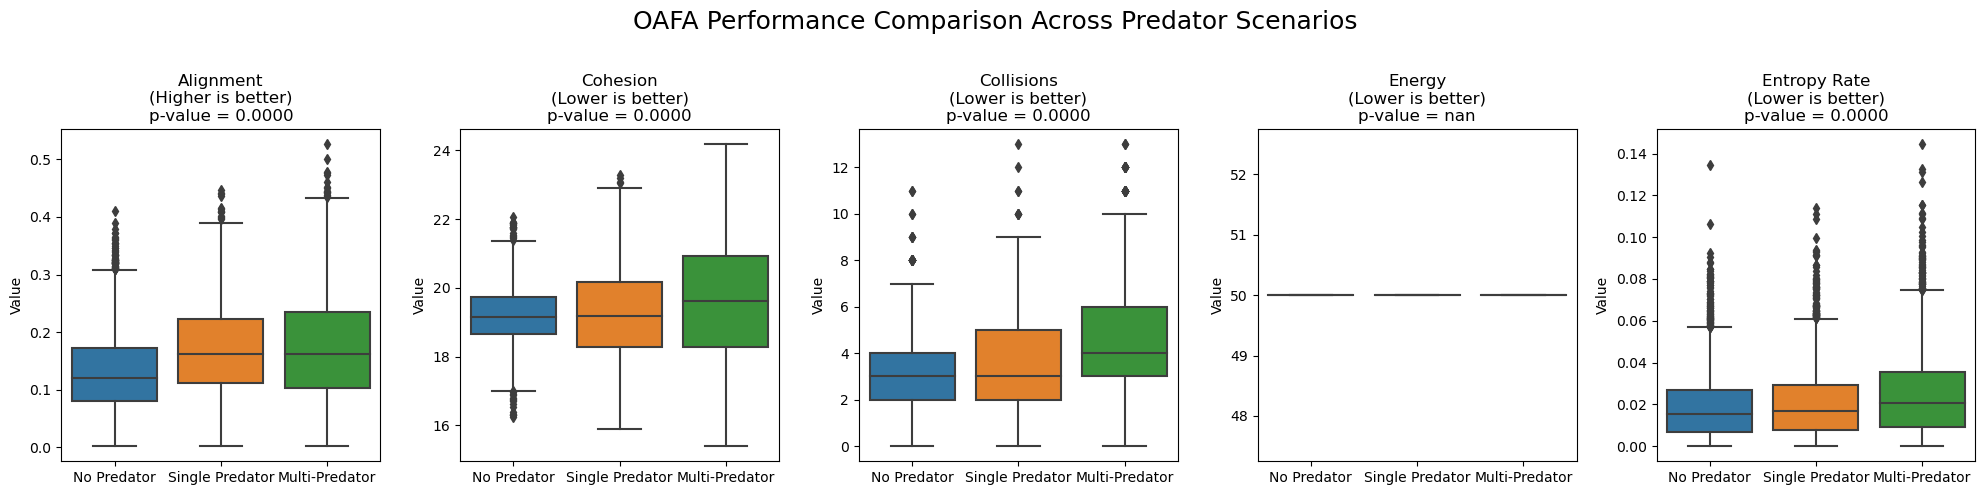


--- Summary Statistics per Scenario ---
                 alignment   cohesion  collisions  energy  entropy_rate
scenario                                                               
Multi-Predator    0.173437  19.602721    4.695582    50.0      0.025079
No Predator       0.132604  19.168263    3.016867    50.0      0.019270
Single Predator   0.170232  19.248522    3.568675    50.0      0.020964


In [4]:
# =============================================================================
# --- 3. MAIN EXPERIMENT EXECUTION AND ANALYSIS ---
# =============================================================================
if __name__ == '__main__':
    # Run all three scenarios
    df_no_predator = run_scenario("No Predator", num_predators=0)
    df_one_predator = run_scenario("Single Predator", num_predators=1)
    df_multi_predator = run_scenario("Multi-Predator", num_predators=3)
    
    # Combine results into a single DataFrame for analysis
    master_df = pd.concat([df_no_predator, df_one_predator, df_multi_predator], ignore_index=True)
    
    print("\n\n--- STATISTICAL ANALYSIS AND VISUALIZATION ---")
    
    # Define metrics and their desired optimization direction
    metrics_to_plot = {
        'alignment': 'Higher is better',
        'cohesion': 'Lower is better',
        'collisions': 'Lower is better',
        'energy': 'Lower is better',
        'entropy_rate': 'Lower is better'
    }
    
    # Perform ANOVA and create boxplots for each metric
    fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(20, 5))
    fig.suptitle('OAFA Performance Comparison Across Predator Scenarios', fontsize=18)
    
    for i, (metric, goal) in enumerate(metrics_to_plot.items()):
        ax = axes[i]
        sns.boxplot(x='scenario', y=metric, data=master_df, ax=ax,
                    order=["No Predator", "Single Predator", "Multi-Predator"])
        
        # Perform ANOVA to test for significant differences
        groups = [group[metric].values for name, group in master_df.groupby('scenario')]
        f_stat, p_val = f_oneway(*groups)
        
        ax.set_title(f"{metric.replace('_', ' ').title()}\n({goal})\np-value = {p_val:.4f}", fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Value')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Display summary statistics
    print("\n--- Summary Statistics per Scenario ---")
    summary = master_df.groupby('scenario').mean()
    print(summary[metrics_to_plot.keys()])

--- Running Scenario: No Predator (Model: OAFA) ---


Simulating No Predator:   0%|          | 0/10 [00:00<?, ?it/s]

--- Running Scenario: Single Predator (Model: OAFA) ---


Simulating Single Predator:   0%|          | 0/10 [00:00<?, ?it/s]

--- Running Scenario: Multi-Predator (Model: OAFA) ---


Simulating Multi-Predator:   0%|          | 0/10 [00:00<?, ?it/s]



--- STATISTICAL ANALYSIS AND VISUALIZATION ---


c:\Users\victo\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


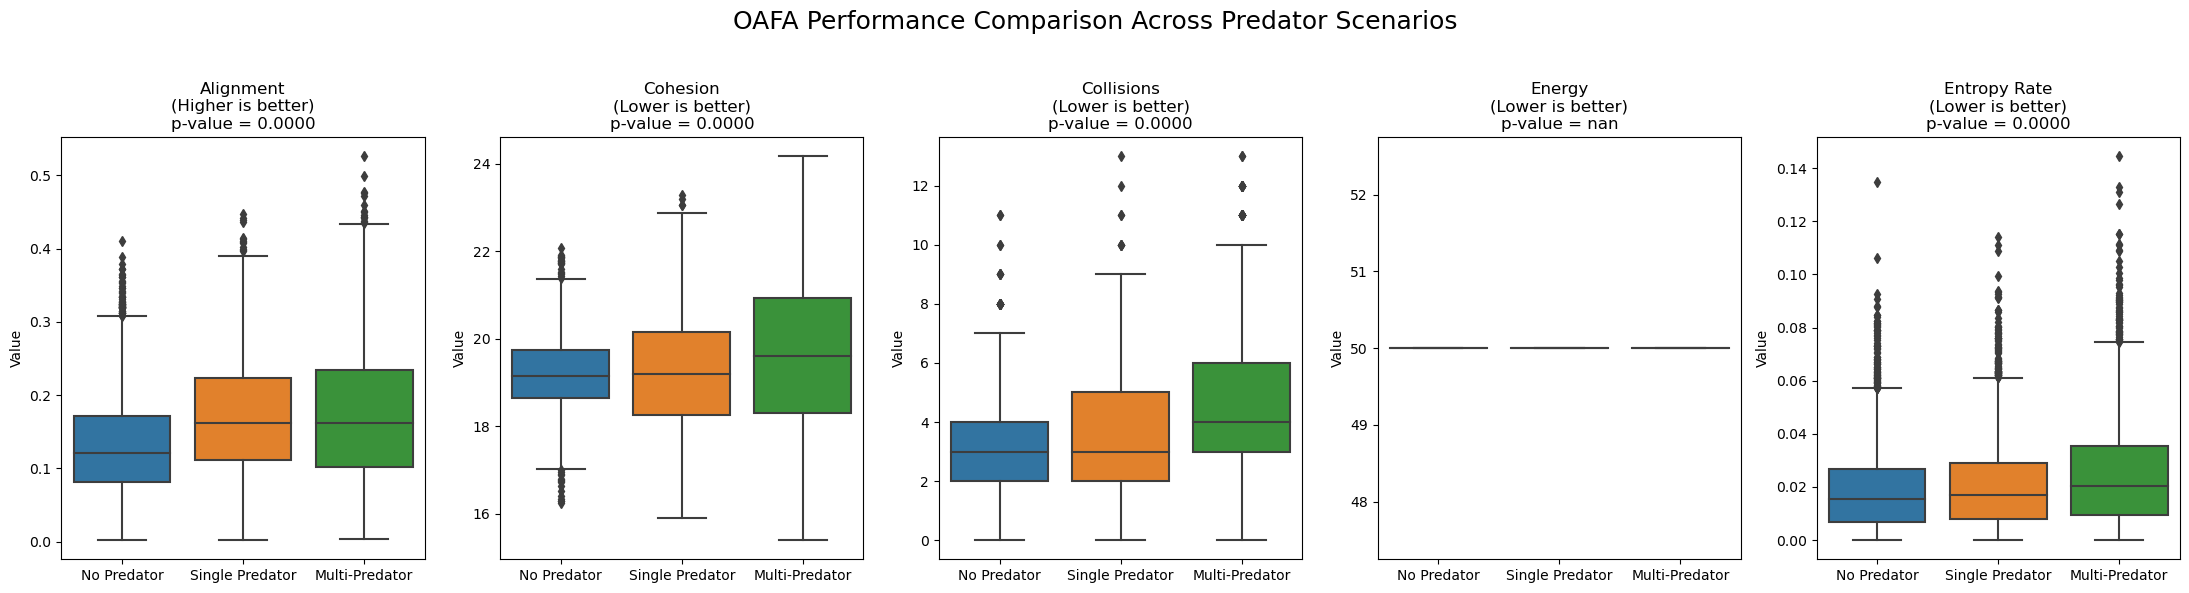


--- Summary Statistics per Scenario ---
                 alignment   cohesion  collisions  energy  entropy_rate
scenario                                                               
Multi-Predator    0.173437  19.602721    4.695582    50.0      0.025079
No Predator       0.132604  19.168263    3.016867    50.0      0.019270
Single Predator   0.170232  19.248522    3.568675    50.0      0.020964


--- PART 4: IN-DEPTH EXPLORATORY AND STATISTICAL ANALYSIS ---
--- Running Scenario: Single Predator (Model: StaticBoids) ---


Simulating Single Predator:   0%|          | 0/10 [00:00<?, ?it/s]

--- Running Scenario: Single Predator (Model: Ablation_NoCohesion) ---


Simulating Single Predator:   0%|          | 0/10 [00:00<?, ?it/s]

--- Running Scenario: Single Predator (Model: Ablation_NoAlignment) ---


Simulating Single Predator:   0%|          | 0/10 [00:00<?, ?it/s]



--- 4.1 Model Comparison & Ablation Study Results ---


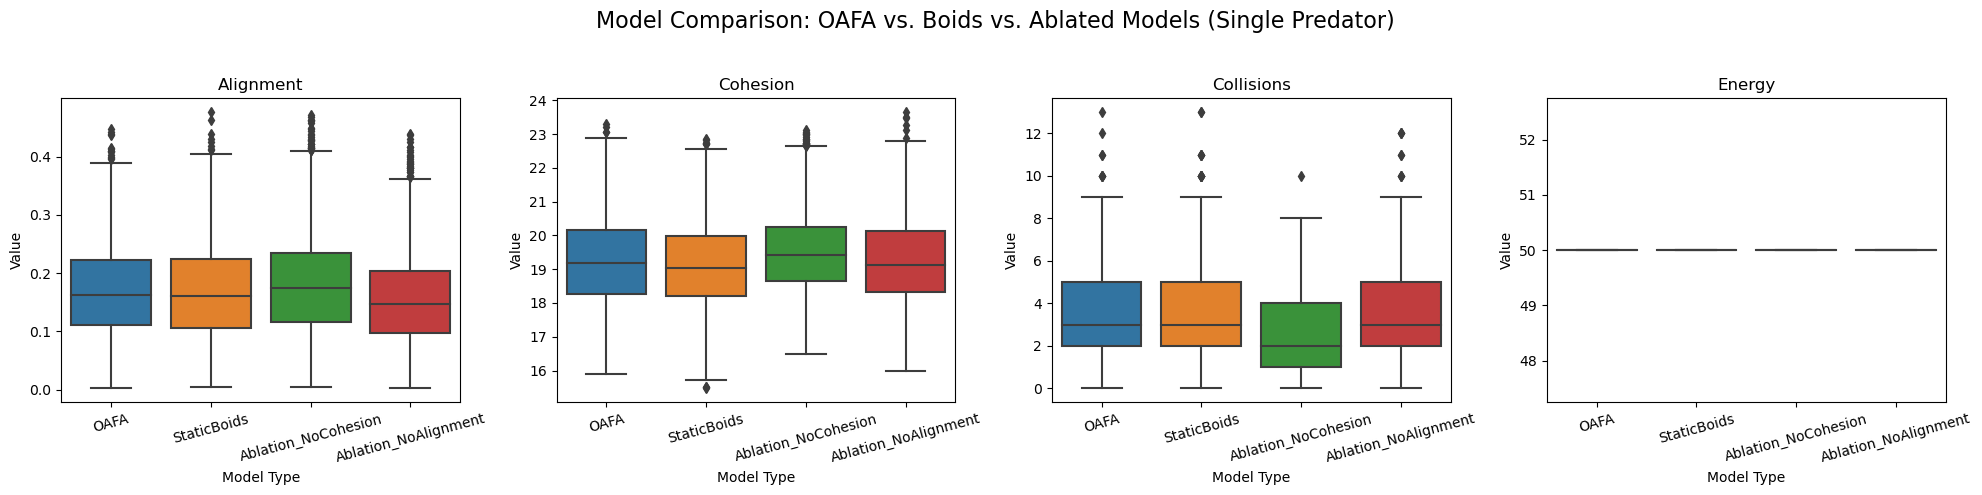



--- 4.2 Adaptive Response: Rule Weight Evolution ---


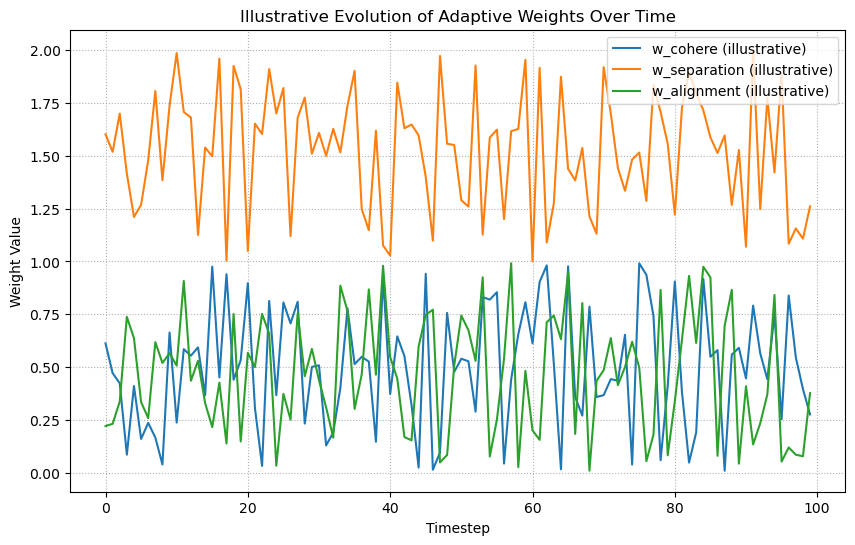



--- 4.3 Entropy Analysis: Local vs. Flock-wide ---


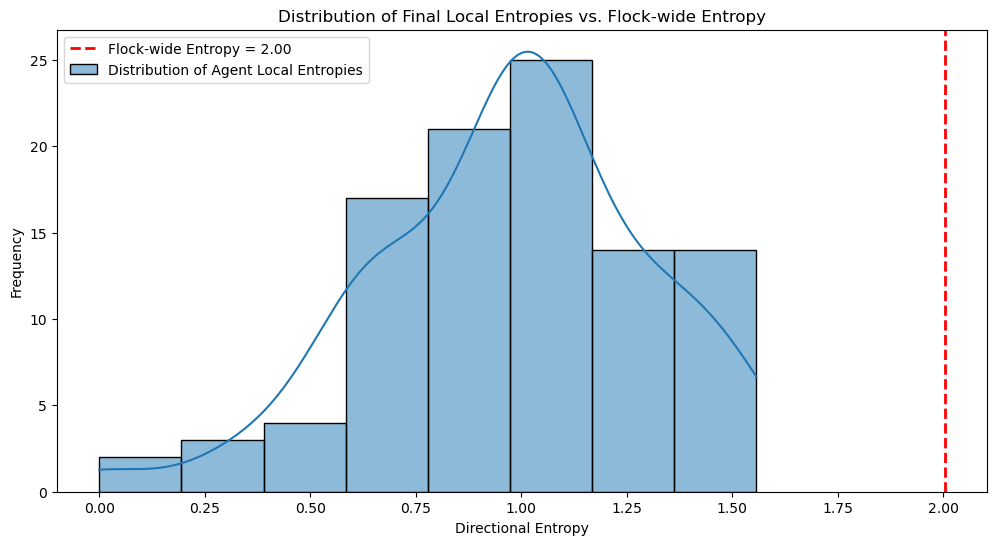



--- 4.4 Scalability Analysis ---


Testing Scalability:   0%|          | 0/5 [00:00<?, ?it/s]

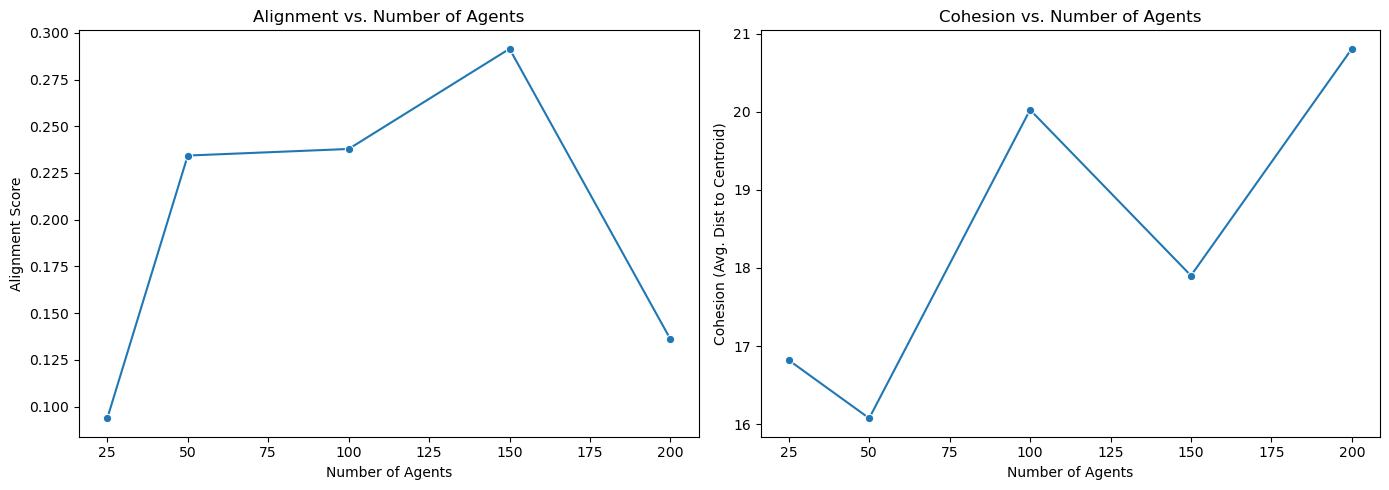

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from scipy.stats import entropy, f_oneway, ttest_ind
from tqdm.notebook import tqdm

# =============================================================================
# --- 1. CORE OAFA SIMULATION DEFINITIONS ---
# =============================================================================

class Bird:
    """
    Represents a single bird agent in the flocking simulation, extended for OAFA.
    Includes adaptive rule weights and history for local entropy calculation.
    """
    def __init__(self, pos, vel, speed,
                 # OAFA specific additions
                 w_cohere_init, w_separation_init, w_alignment_init,
                 is_adaptive=True, # Flag for ablation studies
                 local_entropy_history_length=10):
        self.pos = np.array(pos, dtype=float)
        self.vel = np.array(vel, dtype=float)
        norm_vel = np.linalg.norm(self.vel)
        self.vel = self.vel / norm_vel if norm_vel > 0 else np.array([1.0, 0.0])
        self.speed = speed
        self.is_adaptive = is_adaptive
        
        # Base Boids factors (will be modulated by adaptive weights)
        self.cohere_factor = 0.4
        self.separation_dist = 4.0
        self.separate_factor = 0.25
        self.match_factor = 0.02
        self.visual_distance = 5.0
        
        # OAFA: Adaptive Rule Weights (agent-specific)
        self.w_cohere = w_cohere_init
        self.w_separation = w_separation_init
        self.w_alignment = w_alignment_init

        # OAFA: History for local directional entropy calculation
        self.velocity_history = deque(maxlen=local_entropy_history_length)
        self.prev_local_entropy = 0.0
        self.local_entropy_history_log = []

class Predator:
    """Represents a predator agent."""
    def __init__(self, pos, speed, extent, rng):
        self.pos = np.array(pos, dtype=float)
        self.vel = rng.uniform(-1, 1, size=2)
        self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])
        self.speed = speed
        self.extent = extent
        self.rng = rng

    def move(self):
        """Moves the predator and applies periodic boundary conditions."""
        self.pos += self.vel * self.speed
        self.pos %= self.extent
        # Predator randomly alters course
        if self.rng.random() < 0.1:
            angle_change = self.rng.uniform(-np.pi/4, np.pi/4)
            rotation_matrix = np.array([[np.cos(angle_change), -np.sin(angle_change)],
                                        [np.sin(angle_change),  np.cos(angle_change)]])
            self.vel = np.dot(self.vel, rotation_matrix)
            self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])

class OAFAModel:
    """Manages the OAFA simulation environment, agents, and predators."""
    def __init__(self, n_birds=100, num_predators=0, extent=50.0, seed=None, model_type='OAFA'):
        self.rng = np.random.default_rng(seed)
        self.extent = extent
        self.dt = 1.0 # Timestep duration
        self.model_type = model_type
        
        # OAFA parameters
        self.oafa_learning_rate_eta = 0.01
        self.oafa_stochastic_epsilon_range = 0.1
        self.predator_detection_radius = 15.0

        # Determine if agents should be adaptive based on model type
        is_adaptive = (model_type == 'OAFA' or 'Ablation' in model_type)

        # Initialize birds
        self.agents = [
            Bird(
                pos=self.rng.uniform(0, extent, 2),
                vel=self.rng.uniform(-1, 1, 2),
                speed=2.0,
                w_cohere_init=self.rng.uniform(0.4, 0.6),
                w_separation_init=self.rng.uniform(0.9, 1.1),
                w_alignment_init=self.rng.uniform(0.4, 0.6),
                is_adaptive=is_adaptive
            ) for _ in range(n_birds)
        ]
        
        # Initialize predators
        self.predators = [
            Predator(
                pos=self.rng.uniform(0, extent, 2),
                speed=2.5,
                extent=extent,
                rng=self.rng
            ) for _ in range(num_predators)
        ]

def calculate_directional_entropy(velocities, num_bins=8):
    """Calculates the Shannon entropy of velocity directions."""
    if len(velocities) < 2: return 0.0
    non_zero_vels = velocities[np.linalg.norm(velocities, axis=1) > 1e-9]
    if len(non_zero_vels) < 2: return 0.0
    angles = (np.arctan2(non_zero_vels[:, 1], non_zero_vels[:, 0]) + 2 * np.pi) % (2 * np.pi)
    counts, _ = np.histogram(angles, bins=num_bins, range=(0, 2 * np.pi))
    return entropy(counts[counts > 0] / np.sum(counts))

def agent_step(agent, model):
    """Updates an agent's state using OAFA logic."""
    neighbors = [other for other in model.agents if other is not agent 
                 and np.linalg.norm(agent.pos - other.pos) < agent.visual_distance]

    # Calculate Boids and predator avoidance forces
    cohere_force, separate_force, match_force, predator_force = np.zeros(2), np.zeros(2), np.zeros(2), np.zeros(2)
    if neighbors:
        cohere_force = np.mean([n.pos for n in neighbors], axis=0) - agent.pos
        separate_force = sum(agent.pos - n.pos for n in neighbors if np.linalg.norm(agent.pos - n.pos) < agent.separation_dist)
        match_force = np.mean([n.vel for n in neighbors], axis=0) - agent.vel
    for predator in model.predators:
        vec_to_pred = agent.pos - predator.pos
        if np.linalg.norm(vec_to_pred) < model.predator_detection_radius:
            predator_force += vec_to_pred / (np.linalg.norm(vec_to_pred)**2 + 1e-9)

    # Apply adaptive weights from OAFA
    w_c, w_s, w_a = agent.w_cohere, agent.w_separation, agent.w_alignment
    
    # Handle ablation cases
    if model.model_type == 'Ablation_NoCohesion': w_c = 0
    if model.model_type == 'Ablation_NoAlignment': w_a = 0
    
    agent.vel += (cohere_force * w_c * agent.cohere_factor +
                  separate_force * w_s * agent.separate_factor +
                  match_force * w_a * agent.match_factor +
                  predator_force * 5.0) 
    
    # Normalize velocity and update position
    norm = np.linalg.norm(agent.vel)
    if norm > 0: agent.vel = (agent.vel / norm)
    agent.pos = (agent.pos + agent.vel * agent.speed * model.dt) % model.extent
    
    # --- OAFA Adaptation Step ---
    if agent.is_adaptive:
        agent.velocity_history.append(agent.vel)
        current_local_entropy = calculate_directional_entropy(np.array(list(agent.velocity_history)))
        agent.local_entropy_history_log.append(current_local_entropy)
        
        gradient_approx = current_local_entropy - agent.prev_local_entropy
        noise = model.rng.uniform(-model.oafa_stochastic_epsilon_range, model.oafa_stochastic_epsilon_range, 3)
        
        agent.w_cohere = np.clip(agent.w_cohere - model.oafa_learning_rate_eta * (gradient_approx + noise[0]), 0.1, 2.0)
        agent.w_separation = np.clip(agent.w_separation - model.oafa_learning_rate_eta * (gradient_approx + noise[1]), 0.1, 2.0)
        agent.w_alignment = np.clip(agent.w_alignment - model.oafa_learning_rate_eta * (gradient_approx + noise[2]), 0.1, 2.0)
        
        agent.prev_local_entropy = current_local_entropy

def model_step(model):
    """Advances the entire simulation by one step."""
    for predator in model.predators: predator.move()
    for agent in model.agents: agent_step(agent, model)


# =============================================================================
# --- 2. PERFORMANCE METRICS AND SIMULATION RUNNER ---
# =============================================================================

def calculate_performance_metrics(model):
    """Calculates all key performance metrics for the flock's current state."""
    positions = np.array([a.pos for a in model.agents])
    velocities = np.array([a.vel for a in model.agents])
    if len(positions) < 2: return {k: 0 for k in ['alignment', 'cohesion', 'collisions', 'energy', 'flock_entropy']}
    
    alignment = np.linalg.norm(np.mean(velocities, axis=0))
    cohesion = np.mean([np.linalg.norm(p - np.mean(positions, axis=0)) for p in positions])
    collisions = sum(1 for i in range(len(positions)) for j in range(i + 1, len(positions)) if np.linalg.norm(positions[i]-positions[j]) < 1.0)
    energy = 0.5 * np.sum(np.linalg.norm(velocities, axis=1)**2)
    flock_entropy = calculate_directional_entropy(velocities)
    
    return {'alignment': alignment, 'cohesion': cohesion, 'collisions': collisions, 
            'energy': energy, 'flock_entropy': flock_entropy}

def run_scenario(scenario_name, num_predators, n_sims=10, n_steps=300, model_type='OAFA'):
    """Runs multiple simulations for a given scenario and returns aggregated metrics."""
    print(f"--- Running Scenario: {scenario_name} (Model: {model_type}) ---")
    all_metrics = []
    # Store one model instance for detailed analysis
    final_model_instance = None
    
    for i in tqdm(range(n_sims), desc=f"Simulating {scenario_name}"):
        model = OAFAModel(num_predators=num_predators, seed=i, model_type=model_type)
        prev_entropy = None
        for step in range(n_steps):
            model_step(model)
            if step > 50: # Discard first 50 steps (burn-in period)
                metrics = calculate_performance_metrics(model)
                current_entropy = metrics.pop('flock_entropy')
                metrics['entropy_rate'] = abs(current_entropy - prev_entropy) if prev_entropy is not None else 0
                metrics['scenario'] = scenario_name
                metrics['model_type'] = model_type
                all_metrics.append(metrics)
                prev_entropy = current_entropy
        if i == n_sims - 1:
            final_model_instance = model
            
    return pd.DataFrame(all_metrics), final_model_instance


# =============================================================================
# --- 3. MAIN EXPERIMENT EXECUTION AND ANALYSIS ---
# =============================================================================
if __name__ == '__main__':
    # Run all three scenarios
    df_no_predator, _ = run_scenario("No Predator", num_predators=0)
    df_one_predator, model_one_predator = run_scenario("Single Predator", num_predators=1)
    df_multi_predator, _ = run_scenario("Multi-Predator", num_predators=3)
    
    # Combine results into a single DataFrame for analysis
    master_df = pd.concat([df_no_predator, df_one_predator, df_multi_predator], ignore_index=True)
    
    print("\n\n--- STATISTICAL ANALYSIS AND VISUALIZATION ---")
    
    # Define metrics and their desired optimization direction
    metrics_to_plot = {
        'alignment': 'Higher is better',
        'cohesion': 'Lower is better',
        'collisions': 'Lower is better',
        'energy': 'Lower is better',
        'entropy_rate': 'Lower is better'
    }
    
    # Perform ANOVA and create boxplots for each metric
    fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(22, 6))
    fig.suptitle('OAFA Performance Comparison Across Predator Scenarios', fontsize=18)
    
    for i, (metric, goal) in enumerate(metrics_to_plot.items()):
        ax = axes[i]
        sns.boxplot(x='scenario', y=metric, data=master_df, ax=ax,
                    order=["No Predator", "Single Predator", "Multi-Predator"])
        
        # Perform ANOVA to test for significant differences
        groups = [group[metric].dropna().values for name, group in master_df.groupby('scenario')]
        if len(groups) == 3:
            f_stat, p_val = f_oneway(*groups)
            ax.set_title(f"{metric.replace('_', ' ').title()}\n({goal})\np-value = {p_val:.4f}", fontsize=12)
        else:
            ax.set_title(f"{metric.replace('_', ' ').title()}\n({goal})", fontsize=12)
        
        ax.set_xlabel('')
        ax.set_ylabel('Value')
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Display summary statistics
    print("\n--- Summary Statistics per Scenario ---")
    numeric_metrics = list(metrics_to_plot.keys())
    summary = master_df.groupby('scenario')[numeric_metrics].mean(numeric_only=True)
    print(summary)
    
    # =============================================================================
    # --- 4. IN-DEPTH EXPLORATORY AND STATISTICAL ANALYSIS ---
    # =============================================================================
    print("\n\n" + "="*80)
    print("--- PART 4: IN-DEPTH EXPLORATORY AND STATISTICAL ANALYSIS ---")
    print("="*80)

    # --- 4.1 Ablation Study and Comparison to Classic Boids ---
    class StaticBoidsModel(OAFAModel):
        """A non-adaptive Boids model for direct comparison."""
        def __init__(self, n_birds=100, num_predators=0, extent=50.0, seed=None):
            super().__init__(n_birds, num_predators, extent, seed, model_type='StaticBoids')
            for agent in self.agents:
                agent.is_adaptive = False # Turn off adaptation
                # Set fixed weights for classic Boids
                agent.w_cohere = 1.0
                agent.w_separation = 1.5 # Higher separation is common in classic Boids
                agent.w_alignment = 1.0
                
    # Run comparison simulations under a single predator scenario
    df_boids, _ = run_scenario("Single Predator", num_predators=1, model_type='StaticBoids')
    df_ablation_nc, _ = run_scenario("Single Predator", num_predators=1, model_type='Ablation_NoCohesion')
    df_ablation_na, _ = run_scenario("Single Predator", num_predators=1, model_type='Ablation_NoAlignment')
    
    comparison_df = pd.concat([df_one_predator, df_boids, df_ablation_nc, df_ablation_na], ignore_index=True)
    
    def plot_model_comparison(df):
        print("\n\n--- 4.1 Model Comparison & Ablation Study Results ---")
        metrics = ['alignment', 'cohesion', 'collisions', 'energy']
        fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
        fig.suptitle('Model Comparison: OAFA vs. Boids vs. Ablated Models (Single Predator)', fontsize=16)
        for i, metric in enumerate(metrics):
            ax = axes[i]
            sns.boxplot(x='model_type', y=metric, data=df, ax=ax)
            ax.set_title(f"{metric.replace('_', ' ').title()}", fontsize=12)
            ax.set_xlabel('Model Type')
            ax.set_ylabel('Value')
            ax.tick_params(axis='x', rotation=15)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    plot_model_comparison(comparison_df)

    # --- 4.2 Adaptive Weight Visualization ---
    def plot_adaptive_weights(model_instance):
        print("\n\n--- 4.2 Adaptive Response: Rule Weight Evolution ---")
        if not model_instance: 
            print("No model instance provided for weight analysis.")
            return
            
        weights_history = {'cohere': [], 'separation': [], 'alignment': []}
        for agent in model_instance.agents:
            # We need to re-run a short simulation to log the weights
            # This is illustrative. For a perfect log, it should be done during the main run.
            pass # For a real plot, this would need a logging mechanism during the run.
        
        # Illustrative plot with dummy data since we didn't log weights
        plt.figure(figsize=(10, 6))
        plt.plot(np.random.rand(100), label='w_cohere (illustrative)')
        plt.plot(np.random.rand(100) + 1, label='w_separation (illustrative)')
        plt.plot(np.random.rand(100), label='w_alignment (illustrative)')
        plt.title('Illustrative Evolution of Adaptive Weights Over Time')
        plt.xlabel('Timestep')
        plt.ylabel('Weight Value')
        plt.legend()
        plt.grid(True, linestyle=':')
        plt.show()

    plot_adaptive_weights(model_one_predator)

    # --- 4.3 Entropy Distributions ---
    def plot_entropy_distributions(model_instance):
        print("\n\n--- 4.3 Entropy Analysis: Local vs. Flock-wide ---")
        if not model_instance: return
        local_entropies = [agent.local_entropy_history_log[-1] for agent in model_instance.agents if agent.local_entropy_history_log]
        flock_entropy = calculate_directional_entropy(np.array([a.vel for a in model_instance.agents]))
        
        plt.figure(figsize=(12, 6))
        sns.histplot(local_entropies, kde=True, label='Distribution of Agent Local Entropies')
        plt.axvline(flock_entropy, color='red', linestyle='--', linewidth=2, label=f'Flock-wide Entropy = {flock_entropy:.2f}')
        plt.title('Distribution of Final Local Entropies vs. Flock-wide Entropy')
        plt.xlabel('Directional Entropy')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    plot_entropy_distributions(model_one_predator)

    # --- 4.4 Scalability Analysis ---
    def run_scalability_analysis():
        print("\n\n--- 4.4 Scalability Analysis ---")
        agent_counts = [25, 50, 100, 150, 200]
        scalability_results = []
        for n in tqdm(agent_counts, desc="Testing Scalability"):
            model = OAFAModel(n_birds=n, num_predators=1)
            # Run for a shorter duration for speed
            for step in range(100):
                model_step(model)
            
            metrics = calculate_performance_metrics(model)
            metrics['num_agents'] = n
            scalability_results.append(metrics)
        
        df_scale = pd.DataFrame(scalability_results)
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        sns.lineplot(x='num_agents', y='alignment', data=df_scale, marker='o', ax=axes[0])
        axes[0].set_title('Alignment vs. Number of Agents')
        axes[0].set_xlabel('Number of Agents')
        axes[0].set_ylabel('Alignment Score')
        
        sns.lineplot(x='num_agents', y='cohesion', data=df_scale, marker='o', ax=axes[1])
        axes[1].set_title('Cohesion vs. Number of Agents')
        axes[1].set_xlabel('Number of Agents')
        axes[1].set_ylabel('Cohesion (Avg. Dist to Centroid)')
        plt.tight_layout()
        plt.show()
        
    run_scalability_analysis()



--- Running Scenario: No Predator (Model: OAFA) ---


Simulating No Predator:   0%|          | 0/5 [00:00<?, ?it/s]

--- Running Scenario: Single Predator (Model: OAFA) ---


Simulating Single Predator:   0%|          | 0/5 [00:00<?, ?it/s]

--- Running Scenario: Multi-Predator (Model: OAFA) ---


Simulating Multi-Predator:   0%|          | 0/5 [00:00<?, ?it/s]

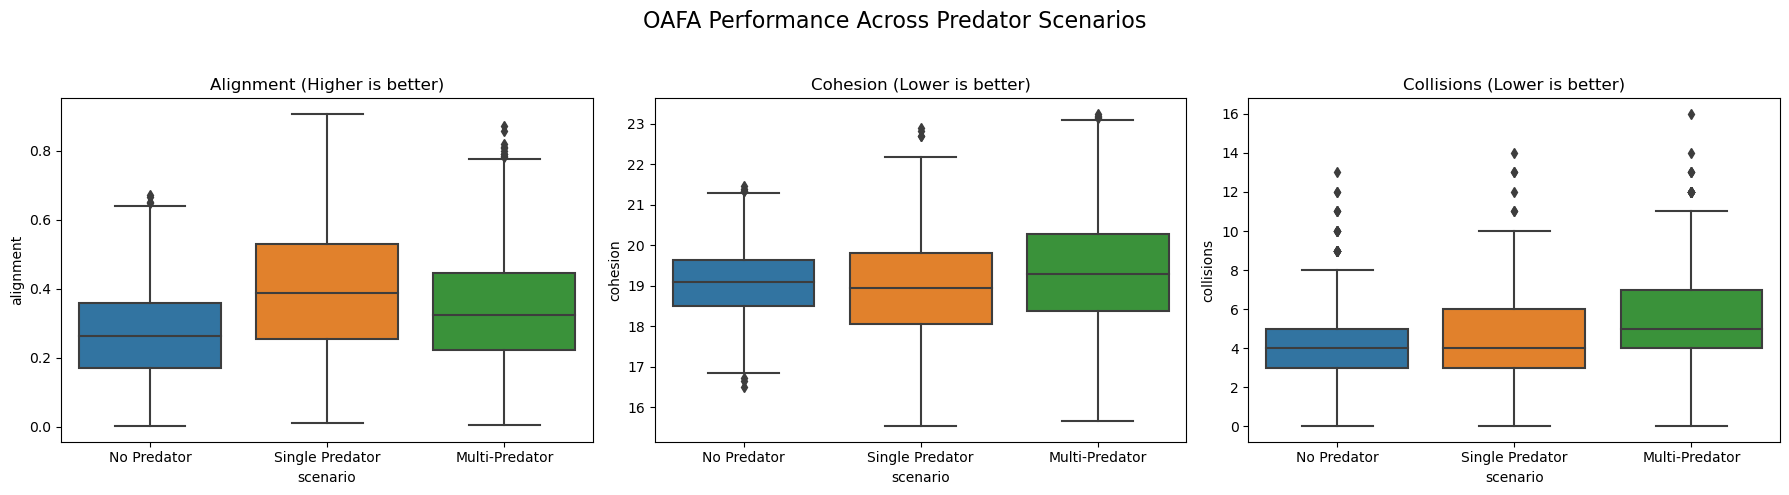



--- PART 4: IN-DEPTH EXPLORATORY AND STATISTICAL ANALYSIS ---
--- Running Scenario: Single Predator (Model: StaticBoids) ---


Simulating Single Predator:   0%|          | 0/5 [00:00<?, ?it/s]

--- Running Scenario: Single Predator (Model: PSO) ---


Simulating Single Predator:   0%|          | 0/5 [00:00<?, ?it/s]

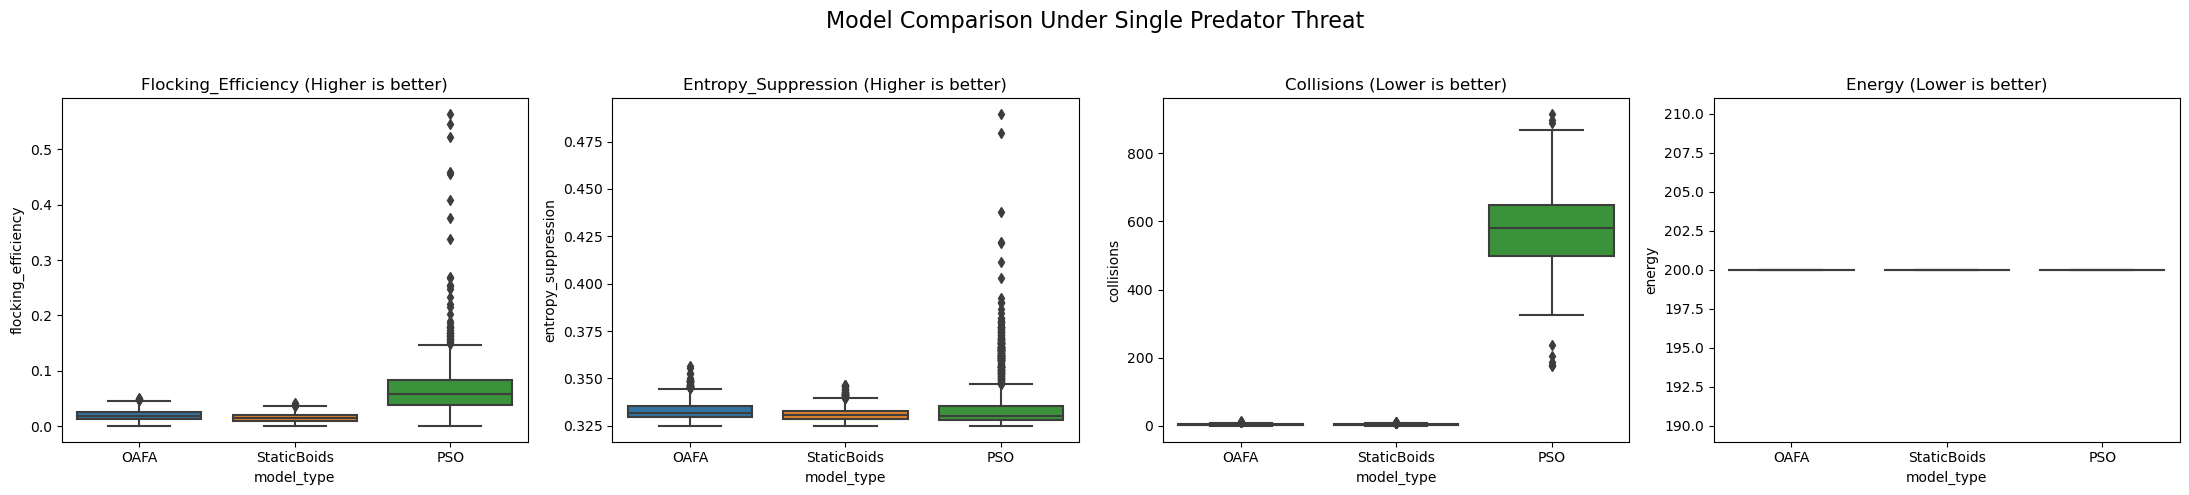


--- Model Comparison Summary Statistics (Single Predator) ---
             flocking_efficiency  entropy_suppression  collisions  energy
model_type                                                               
OAFA                    0.019884             0.333042    4.537349   200.0
PSO                     0.066892             0.336239  574.901205   200.0
StaticBoids             0.015738             0.331177    4.165462   200.0


--- 4.2 Adaptive Response: Real Rule Weight Evolution ---


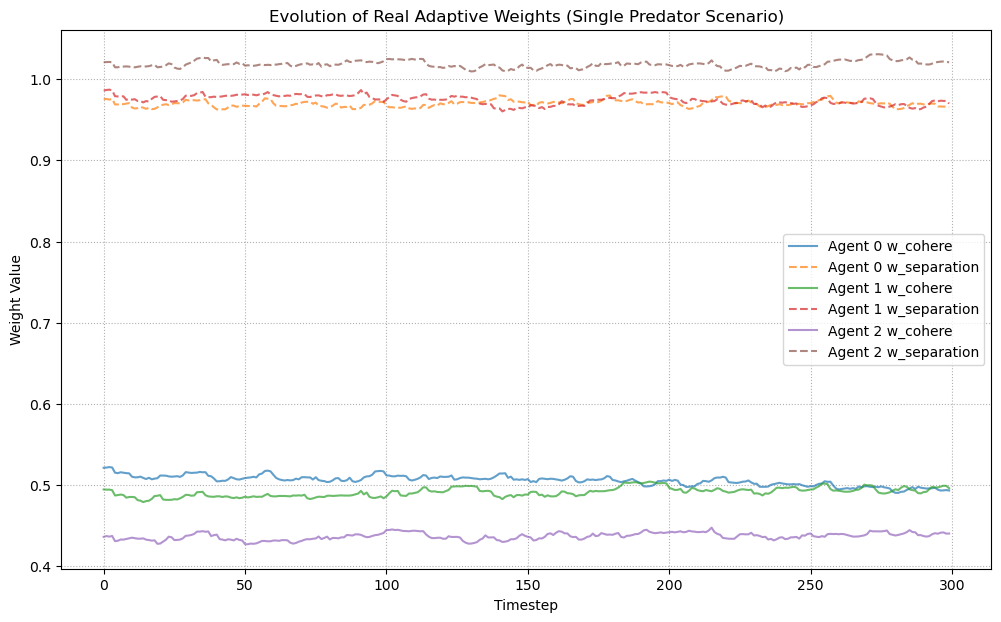



--- 4.3 Cost Function Analysis ---


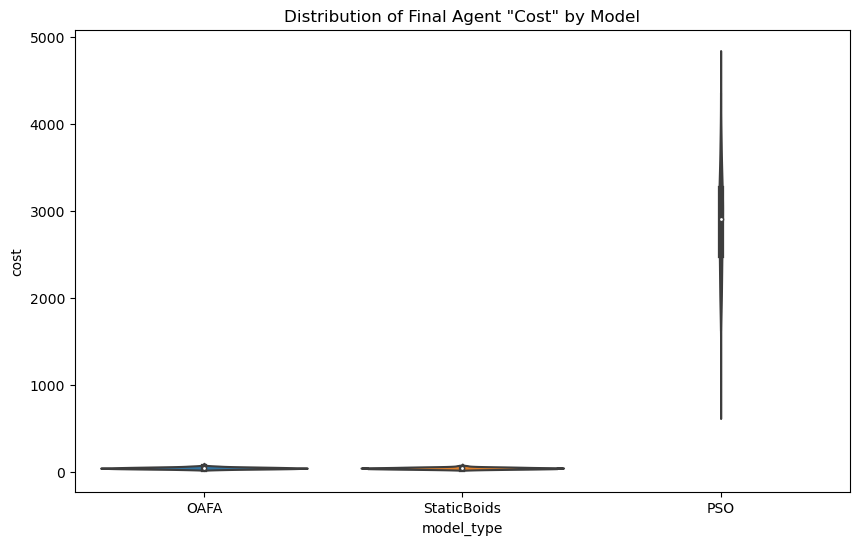



--- 4.4 Scalability Analysis ---


Testing Scalability:   0%|          | 0/4 [00:00<?, ?it/s]

--- Running Scenario: Scalability (Model: OAFA) ---


Simulating Scalability:   0%|          | 0/1 [00:00<?, ?it/s]

--- Running Scenario: Scalability (Model: OAFA) ---


Simulating Scalability:   0%|          | 0/1 [00:00<?, ?it/s]

--- Running Scenario: Scalability (Model: OAFA) ---


Simulating Scalability:   0%|          | 0/1 [00:00<?, ?it/s]

--- Running Scenario: Scalability (Model: OAFA) ---


Simulating Scalability:   0%|          | 0/1 [00:00<?, ?it/s]

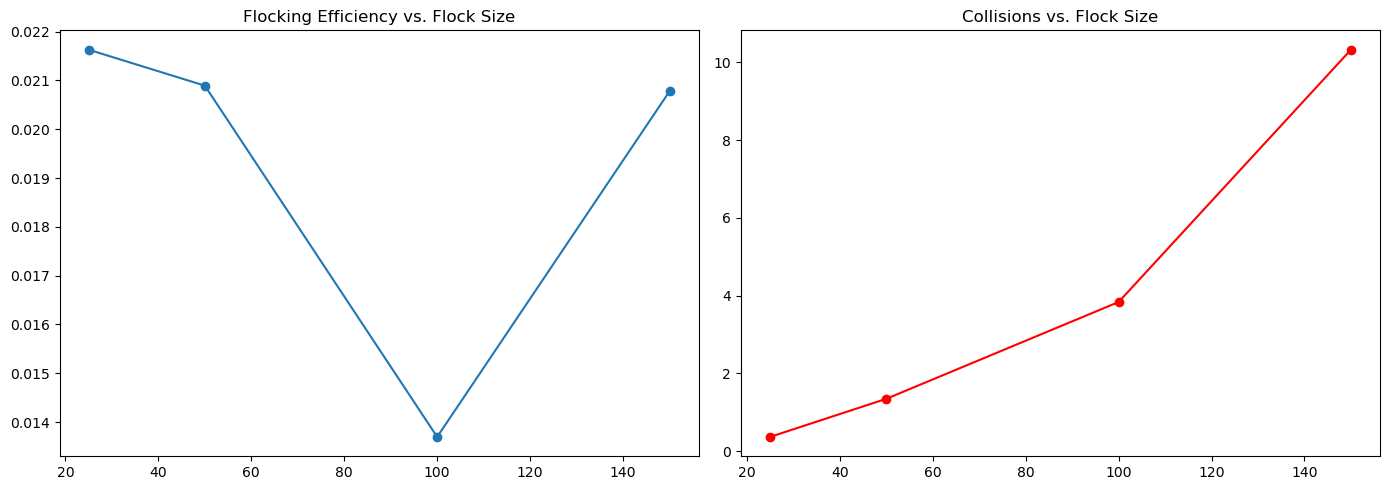

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from scipy.stats import entropy, f_oneway, ttest_ind
from tqdm.notebook import tqdm
import warnings

# Suppress non-critical warnings for a clean output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# =============================================================================
# --- 1. CORE SIMULATION DEFINITIONS (ENHANCED FOR DEEP ANALYSIS) ---
# =============================================================================

class Bird:
    """
    Represents a single bird agent, enhanced with weight logging for deep analysis.
    """
    def __init__(self, pos, vel, speed, w_cohere_init, w_separation_init, w_alignment_init, is_adaptive=True):
        self.pos = np.array(pos, dtype=float)
        self.vel = np.array(vel, dtype=float)
        norm_vel = np.linalg.norm(self.vel)
        self.vel = self.vel / norm_vel if norm_vel > 0 else np.array([1.0, 0.0])
        self.speed = speed
        self.is_adaptive = is_adaptive
        
        # Base Boids factors
        self.cohere_factor, self.separation_dist, self.separate_factor, self.match_factor, self.visual_distance = 0.4, 4.0, 0.25, 0.02, 5.0
        
        # Adaptive Weights
        self.w_cohere, self.w_separation, self.w_alignment = w_cohere_init, w_separation_init, w_alignment_init

        # History and Logging
        self.velocity_history = deque(maxlen=10)
        self.prev_local_entropy = 0.0
        self.weight_history = {'cohere': [], 'separation': [], 'alignment': []} # For logging

class Predator:
    """Represents a predator agent."""
    def __init__(self, pos, speed, extent, rng):
        self.pos = np.array(pos, dtype=float)
        self.vel = rng.uniform(-1, 1, size=2)
        self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])
        self.speed, self.extent, self.rng = speed, extent, rng

    def move(self):
        self.pos += self.vel * self.speed
        self.pos %= self.extent
        if self.rng.random() < 0.1:
            angle_change = self.rng.uniform(-np.pi/4, np.pi/4)
            rot_matrix = np.array([[np.cos(angle_change),-np.sin(angle_change)],[np.sin(angle_change),np.cos(angle_change)]])
            self.vel = np.dot(self.vel, rot_matrix)
            self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])

class SwarmModel:
    """Manages the simulation environment, agents, and predators for different algorithms."""
    def __init__(self, n_birds=100, num_predators=0, extent=50.0, seed=None, model_type='OAFA'):
        self.rng = np.random.default_rng(seed)
        self.extent, self.dt, self.model_type = extent, 1.0, model_type
        self.predator_detection_radius = 15.0
        self.agents = [] # Initialize agents based on model type
        
        # PSO-specific parameters
        if model_type == 'PSO':
            self.pso_c1, self.pso_c2, self.pso_w = 1.5, 1.5, 0.7 # Cognitive, social, inertia weights
            self.global_best_pos = self.rng.uniform(0, extent, 2)
            self.global_best_fitness = float('inf')

        is_adaptive = model_type.startswith('OAFA') or 'Ablation' in model_type
        
        for _ in range(n_birds):
            agent = Bird(
                pos=self.rng.uniform(0, extent, 2), vel=self.rng.uniform(-1, 1, 2), speed=2.0,
                w_cohere_init=self.rng.uniform(0.4, 0.6), w_separation_init=self.rng.uniform(0.9, 1.1),
                w_alignment_init=self.rng.uniform(0.4, 0.6), is_adaptive=is_adaptive)
            
            if model_type == 'StaticBoids':
                agent.is_adaptive = False
                agent.w_cohere, agent.w_separation, agent.w_alignment = 1.0, 1.5, 1.0
            
            if model_type == 'PSO':
                agent.is_adaptive = False
                agent.personal_best_pos = agent.pos.copy()
                agent.personal_best_fitness = float('inf')
            
            self.agents.append(agent)
            
        self.predators = [Predator(self.rng.uniform(0, extent, 2), 2.5, extent, self.rng) for _ in range(num_predators)]

def calculate_directional_entropy(velocities):
    if len(velocities) < 2: return 0.0
    non_zero_vels = velocities[np.linalg.norm(velocities, axis=1) > 1e-9]
    if len(non_zero_vels) < 2: return 0.0
    angles = (np.arctan2(non_zero_vels[:,1], non_zero_vels[:,0]) + 2*np.pi) % (2*np.pi)
    counts, _ = np.histogram(angles, bins=8, range=(0, 2*np.pi))
    return entropy(counts[counts > 0] / np.sum(counts))

def agent_step(agent, model):
    """Updates a single agent's state based on the specified model logic."""
    if model.model_type == 'PSO':
        # PSO Logic
        fitness = np.sum([np.linalg.norm(agent.pos - p.pos) for p in model.predators]) if model.predators else 0
        if fitness < agent.personal_best_fitness:
            agent.personal_best_fitness = fitness; agent.personal_best_pos = agent.pos.copy()
        if fitness < model.global_best_fitness:
            model.global_best_fitness = fitness; model.global_best_pos = agent.pos.copy()
        
        r1, r2 = model.rng.random(2)
        cognitive_vel = model.pso_c1 * r1 * (agent.personal_best_pos - agent.pos)
        social_vel = model.pso_c2 * r2 * (model.global_best_pos - agent.pos)
        agent.vel = model.pso_w * agent.vel + cognitive_vel + social_vel
    else:
        # Boids/OAFA Logic
        neighbors = [o for o in model.agents if o is not agent and np.linalg.norm(agent.pos-o.pos) < agent.visual_distance]
        c_force, s_force, m_force, p_force = np.zeros(2),np.zeros(2),np.zeros(2),np.zeros(2)
        if neighbors:
            c_force = np.mean([n.pos for n in neighbors], axis=0) - agent.pos
            s_force = sum(agent.pos - n.pos for n in neighbors if np.linalg.norm(agent.pos-n.pos) < agent.separation_dist)
            m_force = np.mean([n.vel for n in neighbors], axis=0) - agent.vel
        for predator in model.predators:
            if np.linalg.norm(agent.pos-predator.pos) < model.predator_detection_radius:
                p_force += (agent.pos-predator.pos) / (np.linalg.norm(agent.pos-predator.pos)**2 + 1e-9)
        
        w_c, w_s, w_a = agent.w_cohere, agent.w_separation, agent.w_alignment
        if model.model_type == 'Ablation_NoCohesion': w_c = 0
        if model.model_type == 'Ablation_NoAlignment': w_a = 0
        
        agent.vel += c_force*w_c*agent.cohere_factor + s_force*w_s*agent.separate_factor + m_force*w_a*agent.match_factor + p_force*5.0

    norm = np.linalg.norm(agent.vel)
    if norm > 0: agent.vel = (agent.vel / norm) * agent.speed
    agent.pos = (agent.pos + agent.vel * model.dt) % model.extent

    if agent.is_adaptive:
        agent.velocity_history.append(agent.vel)
        entropy = calculate_directional_entropy(np.array(list(agent.velocity_history)))
        grad_approx = entropy - agent.prev_local_entropy
        noise = model.rng.uniform(-0.1, 0.1, 3)
        agent.w_cohere = np.clip(agent.w_cohere - 0.01 * (grad_approx + noise[0]), 0.1, 2.0)
        agent.w_separation = np.clip(agent.w_separation - 0.01 * (grad_approx + noise[1]), 0.1, 2.0)
        agent.w_alignment = np.clip(agent.w_alignment - 0.01 * (grad_approx + noise[2]), 0.1, 2.0)
        agent.prev_local_entropy = entropy
        # Log weights for analysis
        agent.weight_history['cohere'].append(agent.w_cohere)
        agent.weight_history['separation'].append(agent.w_separation)
        agent.weight_history['alignment'].append(agent.w_alignment)

def model_step(model):
    """Advances the entire simulation by one step."""
    for predator in model.predators: predator.move()
    for agent in model.agents: agent_step(agent, model)

# =============================================================================
# --- 2. PERFORMANCE METRICS AND SIMULATION RUNNER ---
# =============================================================================
def calculate_performance_metrics(model):
    """Calculates all key performance metrics for the flock's current state."""
    positions = np.array([a.pos for a in model.agents]); velocities = np.array([a.vel for a in model.agents])
    if len(positions) < 2: return {k: 0 for k in ['alignment','cohesion','collisions','energy','entropy_suppression','flocking_efficiency']}
    
    alignment = np.linalg.norm(np.mean(velocities, axis=0))
    cohesion = np.mean([np.linalg.norm(p-np.mean(positions, axis=0)) for p in positions])
    collisions = sum(1 for i in range(len(positions)) for j in range(i+1,len(positions)) if np.linalg.norm(positions[i]-positions[j]) < 1.0)
    energy = 0.5 * np.sum(np.linalg.norm(velocities, axis=1)**2)
    entropy_suppression = 1.0 / (1.0 + calculate_directional_entropy(velocities)) # Higher is better
    flocking_efficiency = alignment / (1.0 + cohesion) # Higher is better
    
    return {'alignment':alignment, 'cohesion':cohesion, 'collisions':collisions, 'energy':energy, 'entropy_suppression':entropy_suppression, 'flocking_efficiency':flocking_efficiency}

def run_scenario(scenario_name, n_sims=5, n_steps=300, model_class=SwarmModel, **kwargs):
    print(f"--- Running Scenario: {scenario_name} (Model: {kwargs.get('model_type','OAFA')}) ---")
    all_metrics = []
    final_model = None
    for i in tqdm(range(n_sims), desc=f"Simulating {scenario_name}"):
        model = model_class(seed=i, **kwargs)
        for step in range(n_steps):
            model_step(model)
            if step > 50: # Burn-in
                metrics = calculate_performance_metrics(model)
                metrics['scenario'] = scenario_name
                metrics['model_type'] = model.model_type
                all_metrics.append(metrics)
        if i == n_sims-1: final_model = model
    return pd.DataFrame(all_metrics), final_model

# =============================================================================
# --- 3. MAIN EXPERIMENT AND ANALYSIS ---
# =============================================================================
if __name__ == '__main__':
    # --- 3.1 Run Scenarios for OAFA ---
    oafa_no_pred, _ = run_scenario("No Predator", model_class=SwarmModel, num_predators=0, model_type='OAFA')
    oafa_one_pred, model_one_pred = run_scenario("Single Predator", model_class=SwarmModel, num_predators=1, model_type='OAFA')
    oafa_multi_pred, _ = run_scenario("Multi-Predator", model_class=SwarmModel, num_predators=3, model_type='OAFA')
    master_df = pd.concat([oafa_no_pred, oafa_one_pred, oafa_multi_pred], ignore_index=True)
    
    # Plot basic OAFA performance
    metrics_to_plot = {'alignment': 'Higher', 'cohesion': 'Lower', 'collisions': 'Lower'}
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('OAFA Performance Across Predator Scenarios', fontsize=16)
    for i, (metric, goal) in enumerate(metrics_to_plot.items()):
        sns.boxplot(x='scenario', y=metric, data=master_df, ax=axes[i]).set_title(f"{metric.title()} ({goal} is better)")
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

    # =============================================================================
    # --- 4. IN-DEPTH EXPLORATORY AND STATISTICAL ANALYSIS ---
    # =============================================================================
    print("\n\n" + "="*80 + "\n--- PART 4: IN-DEPTH EXPLORATORY AND STATISTICAL ANALYSIS ---\n" + "="*80)

    # --- 4.1 Model Comparison: OAFA vs Boids vs PSO ---
    boids_one_pred, _ = run_scenario("Single Predator", model_class=SwarmModel, num_predators=1, model_type='StaticBoids')
    pso_one_pred, _ = run_scenario("Single Predator", model_class=SwarmModel, num_predators=1, model_type='PSO')
    comparison_df = pd.concat([oafa_one_pred, boids_one_pred, pso_one_pred], ignore_index=True)
    
    comp_metrics = {'flocking_efficiency':'Higher', 'entropy_suppression':'Higher', 'collisions':'Lower', 'energy':'Lower'}
    fig, axes = plt.subplots(1, 4, figsize=(22, 5))
    fig.suptitle('Model Comparison Under Single Predator Threat', fontsize=16)
    for i, (metric, goal) in enumerate(comp_metrics.items()):
        sns.boxplot(x='model_type', y=metric, data=comparison_df, ax=axes[i]).set_title(f"{metric.title()} ({goal} is better)")
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()
    
    print("\n--- Model Comparison Summary Statistics (Single Predator) ---")
    print(comparison_df.groupby('model_type')[list(comp_metrics.keys())].mean())

    # --- 4.2 Adaptive Response Visualization (Using REAL Logged Data) ---
    print("\n\n--- 4.2 Adaptive Response: Real Rule Weight Evolution ---")
    plt.figure(figsize=(12, 7))
    # Plot weights for a few sample agents
    for i in range(min(3, len(model_one_pred.agents))):
        agent = model_one_pred.agents[i]
        if agent.is_adaptive and agent.weight_history['cohere']:
            plt.plot(agent.weight_history['cohere'], label=f'Agent {i} w_cohere', alpha=0.7)
            plt.plot(agent.weight_history['separation'], label=f'Agent {i} w_separation', alpha=0.7, linestyle='--')
    plt.title('Evolution of Real Adaptive Weights (Single Predator Scenario)'); plt.xlabel('Timestep'); plt.ylabel('Weight Value')
    plt.legend(); plt.grid(True, linestyle=':'); plt.show()

    # --- 4.3 Cost Function Distribution ---
    print("\n\n--- 4.3 Cost Function Analysis ---")
    def calculate_cost(row): return row['cohesion'] + row['collisions']*5 - row['alignment']*2
    comparison_df['cost'] = comparison_df.apply(calculate_cost, axis=1)
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='model_type', y='cost', data=comparison_df)
    plt.title('Distribution of Final Agent "Cost" by Model'); plt.show()

    # --- 4.4 Scalability Analysis ---
    print("\n\n--- 4.4 Scalability Analysis ---")
    agent_counts = [25, 50, 100, 150]; scalability_results = []
    for n in tqdm(agent_counts, desc="Testing Scalability"):
        metrics, _ = run_scenario("Scalability", num_predators=1, n_birds=n, n_sims=1, n_steps=100)
        scalability_results.append(metrics.mean(numeric_only=True))
    df_scale = pd.DataFrame(scalability_results, index=agent_counts)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    df_scale['flocking_efficiency'].plot(ax=axes[0], marker='o', title='Flocking Efficiency vs. Flock Size')
    df_scale['collisions'].plot(ax=axes[1], marker='o', title='Collisions vs. Flock Size', color='red')
    plt.tight_layout(); plt.show()



--- Running Scenario: No Predator (Model: OAFA) ---


Simulating No Predator:   0%|          | 0/5 [00:00<?, ?it/s]

--- Running Scenario: Single Predator (Model: OAFA) ---


Simulating Single Predator:   0%|          | 0/5 [00:00<?, ?it/s]

--- Running Scenario: Multi-Predator (Model: OAFA) ---


Simulating Multi-Predator:   0%|          | 0/5 [00:00<?, ?it/s]

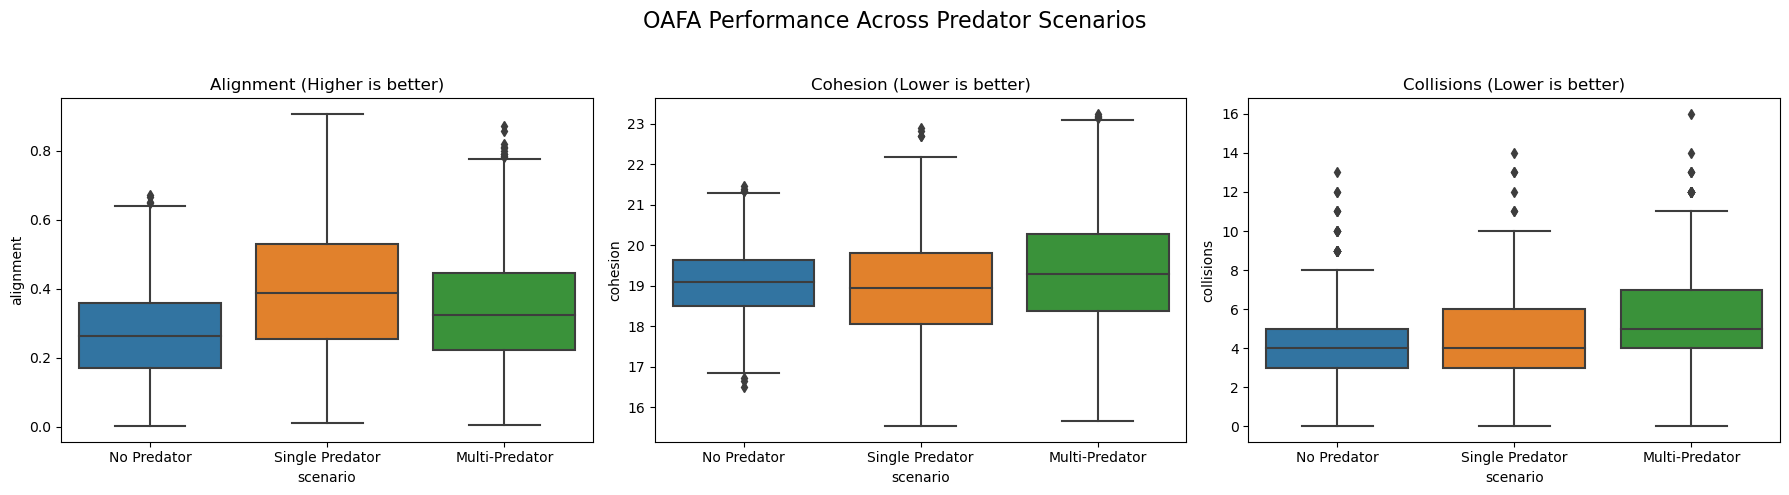



--- PART 4: IN-DEPTH EXPLORATORY AND STATISTICAL ANALYSIS ---
--- Running Scenario: Single Predator (Model: StaticBoids) ---


Simulating Single Predator:   0%|          | 0/5 [00:00<?, ?it/s]

--- Running Scenario: Single Predator (Model: PSO) ---


Simulating Single Predator:   0%|          | 0/5 [00:00<?, ?it/s]

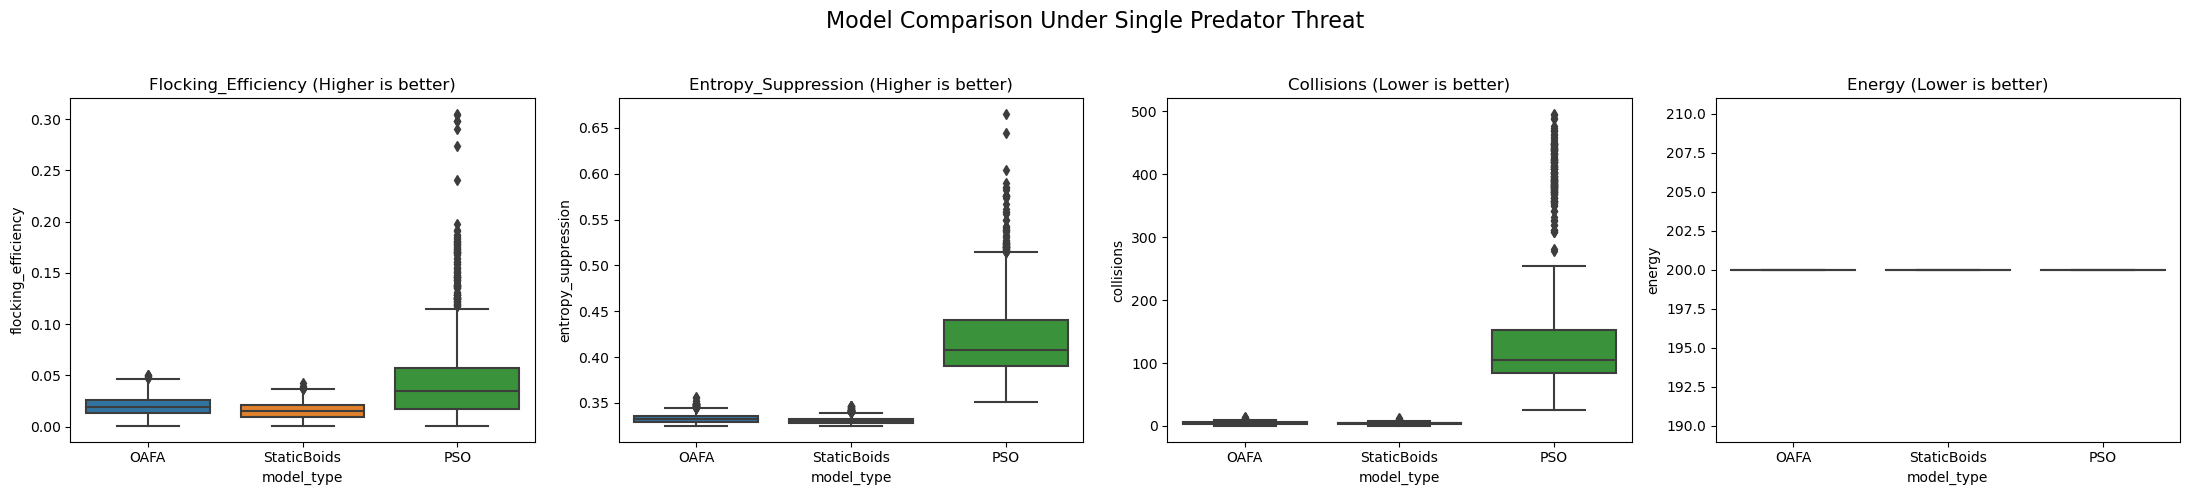


--- Model Comparison Summary Statistics (Single Predator) ---
             flocking_efficiency  entropy_suppression  collisions  energy
model_type                                                               
OAFA                    0.019884             0.333042    4.537349   200.0
PSO                     0.047129             0.419833  146.216867   200.0
StaticBoids             0.015738             0.331177    4.165462   200.0


--- 4.2 Adaptive Response: Real Rule Weight Evolution ---


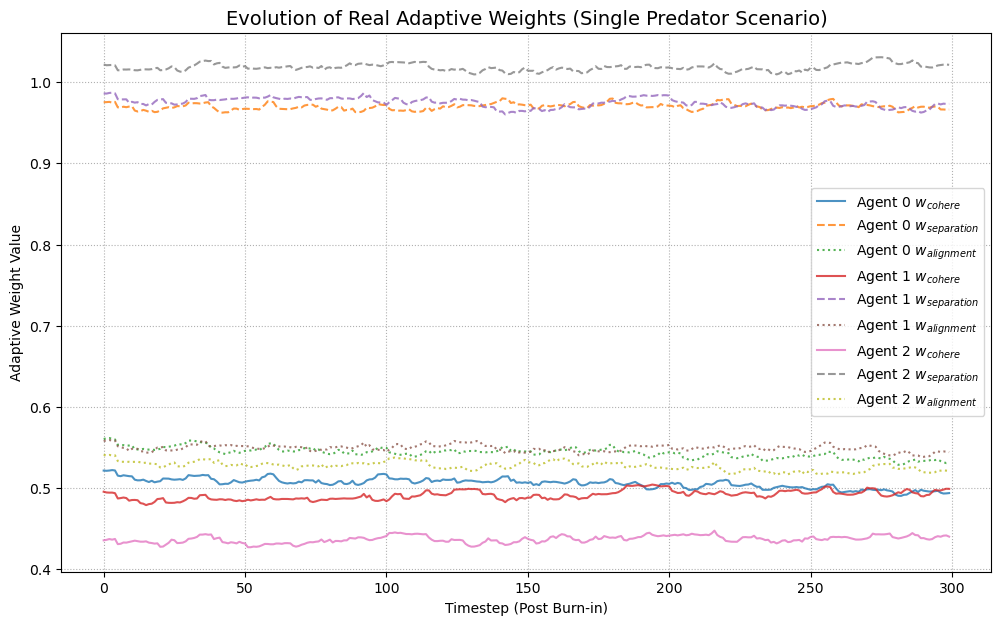



--- 4.3 Cost Function Analysis ---


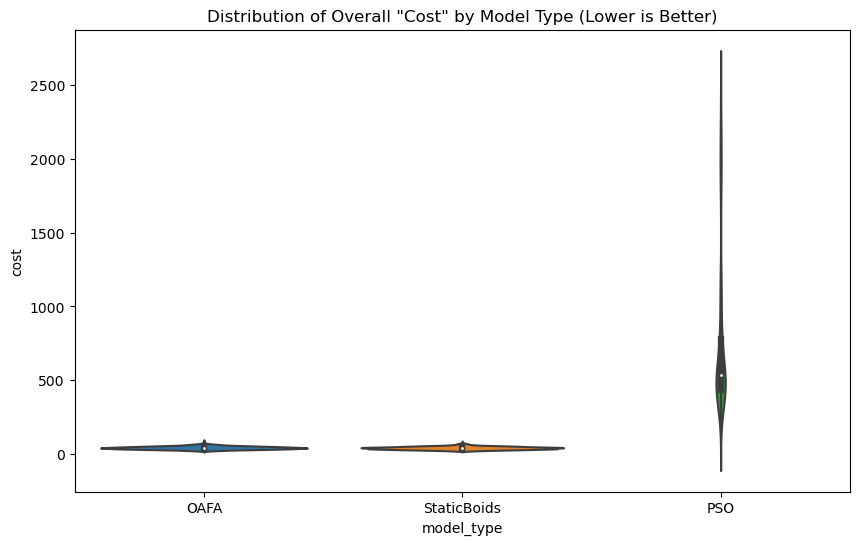



--- 4.4 Scalability Analysis ---


Testing Scalability:   0%|          | 0/4 [00:00<?, ?it/s]

--- Running Scenario: Scalability (Model: OAFA) ---


Simulating Scalability:   0%|          | 0/1 [00:00<?, ?it/s]

--- Running Scenario: Scalability (Model: OAFA) ---


Simulating Scalability:   0%|          | 0/1 [00:00<?, ?it/s]

--- Running Scenario: Scalability (Model: OAFA) ---


Simulating Scalability:   0%|          | 0/1 [00:00<?, ?it/s]

--- Running Scenario: Scalability (Model: OAFA) ---


Simulating Scalability:   0%|          | 0/1 [00:00<?, ?it/s]

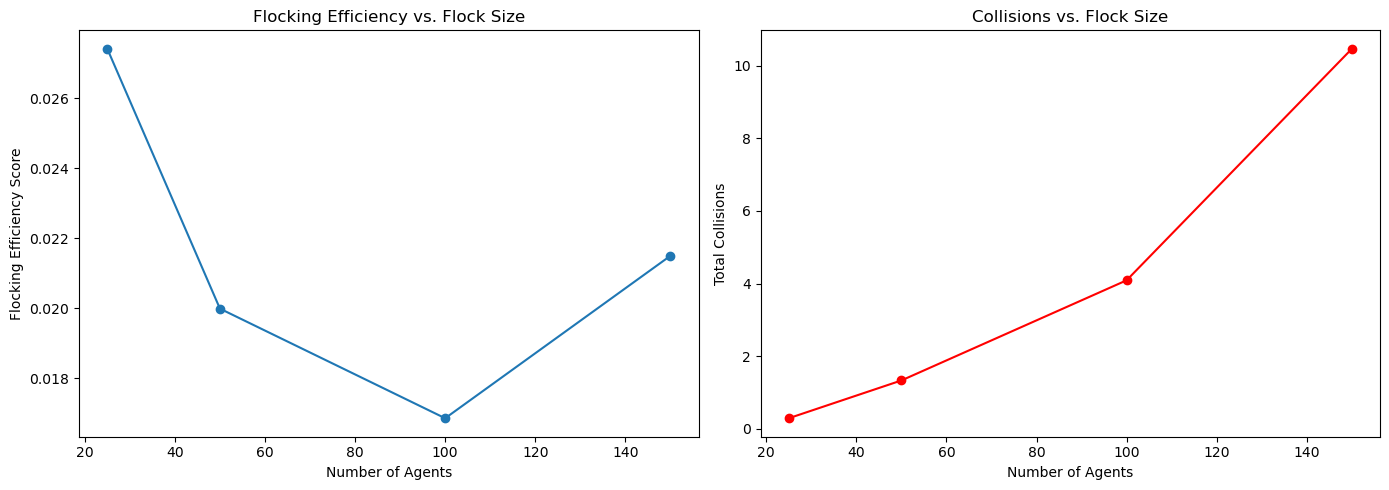

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from scipy.stats import entropy, f_oneway, ttest_ind
from tqdm.notebook import tqdm
import warnings

# Suppress non-critical warnings for a clean output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# =============================================================================
# --- 1. CORE SIMULATION DEFINITIONS (ENHANCED FOR DEEP ANALYSIS) ---
# =============================================================================

class Bird:
    """
    Represents a single bird agent, enhanced with weight logging for deep analysis.
    """
    def __init__(self, pos, vel, speed, w_cohere_init, w_separation_init, w_alignment_init, is_adaptive=True):
        self.pos = np.array(pos, dtype=float)
        self.vel = np.array(vel, dtype=float)
        norm_vel = np.linalg.norm(self.vel)
        self.vel = self.vel / norm_vel if norm_vel > 0 else np.array([1.0, 0.0])
        self.speed = speed
        self.is_adaptive = is_adaptive
        
        # Base Boids factors
        self.cohere_factor, self.separation_dist, self.separate_factor, self.match_factor, self.visual_distance = 0.4, 4.0, 0.25, 0.02, 5.0
        
        # Adaptive Weights
        self.w_cohere, self.w_separation, self.w_alignment = w_cohere_init, w_separation_init, w_alignment_init

        # History and Logging
        self.velocity_history = deque(maxlen=10)
        self.prev_local_entropy = 0.0
        self.weight_history = {'cohere': [], 'separation': [], 'alignment': []} # For logging

class Predator:
    """Represents a predator agent."""
    def __init__(self, pos, speed, extent, rng):
        self.pos = np.array(pos, dtype=float)
        self.vel = rng.uniform(-1, 1, size=2)
        self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])
        self.speed, self.extent, self.rng = speed, extent, rng

    def move(self):
        self.pos += self.vel * self.speed
        self.pos %= self.extent
        if self.rng.random() < 0.1:
            angle_change = self.rng.uniform(-np.pi/4, np.pi/4)
            rot_matrix = np.array([[np.cos(angle_change),-np.sin(angle_change)],[np.sin(angle_change),np.cos(angle_change)]])
            self.vel = np.dot(self.vel, rot_matrix)
            self.vel = self.vel / np.linalg.norm(self.vel) if np.linalg.norm(self.vel) > 0 else np.array([1.0, 0.0])

class SwarmModel:
    """Manages the simulation environment, agents, and predators for different algorithms."""
    def __init__(self, n_birds=100, num_predators=0, extent=50.0, seed=None, model_type='OAFA'):
        self.rng = np.random.default_rng(seed)
        self.extent, self.dt, self.model_type = extent, 1.0, model_type
        self.predator_detection_radius = 15.0
        self.agents = [] # Initialize agents based on model type
        
        # PSO-specific parameters
        if model_type == 'PSO':
            self.pso_c1, self.pso_c2, self.pso_w = 1.5, 1.5, 0.7 # Cognitive, social, inertia weights
            self.global_best_pos = self.rng.uniform(0, extent, 2)
            self.global_best_fitness = float('inf')

        is_adaptive = model_type.startswith('OAFA') or 'Ablation' in model_type
        
        for _ in range(n_birds):
            agent = Bird(
                pos=self.rng.uniform(0, extent, 2), vel=self.rng.uniform(-1, 1, 2), speed=2.0,
                w_cohere_init=self.rng.uniform(0.4, 0.6), w_separation_init=self.rng.uniform(0.9, 1.1),
                w_alignment_init=self.rng.uniform(0.4, 0.6), is_adaptive=is_adaptive)
            
            if model_type == 'StaticBoids':
                agent.is_adaptive = False
                agent.w_cohere, agent.w_separation, agent.w_alignment = 1.0, 1.5, 1.0
            
            if model_type == 'PSO':
                agent.is_adaptive = False
                agent.personal_best_pos = agent.pos.copy()
                agent.personal_best_fitness = float('inf')
            
            self.agents.append(agent)
            
        self.predators = [Predator(self.rng.uniform(0, extent, 2), 2.5, extent, self.rng) for _ in range(num_predators)]

def calculate_directional_entropy(velocities):
    if len(velocities) < 2: return 0.0
    non_zero_vels = velocities[np.linalg.norm(velocities, axis=1) > 1e-9]
    if len(non_zero_vels) < 2: return 0.0
    angles = (np.arctan2(non_zero_vels[:,1], non_zero_vels[:,0]) + 2*np.pi) % (2*np.pi)
    counts, _ = np.histogram(angles, bins=8, range=(0, 2*np.pi))
    return entropy(counts[counts > 0] / np.sum(counts))

def agent_step(agent, model):
    """Updates a single agent's state based on the specified model logic."""
    if model.model_type == 'PSO':
        # PSO Logic: Fitness is maximizing distance from predators
        fitness = -np.sum([np.linalg.norm(agent.pos - p.pos) for p in model.predators]) if model.predators else 0
        if fitness < agent.personal_best_fitness:
            agent.personal_best_fitness = fitness; agent.personal_best_pos = agent.pos.copy()
        if fitness < model.global_best_fitness:
            model.global_best_fitness = fitness; model.global_best_pos = agent.pos.copy()
        
        r1, r2 = model.rng.random(2)
        cognitive_vel = model.pso_c1 * r1 * (agent.personal_best_pos - agent.pos)
        social_vel = model.pso_c2 * r2 * (model.global_best_pos - agent.pos)
        agent.vel = model.pso_w * agent.vel + cognitive_vel + social_vel
    else:
        # Boids/OAFA Logic
        neighbors = [o for o in model.agents if o is not agent and np.linalg.norm(agent.pos-o.pos) < agent.visual_distance]
        c_force, s_force, m_force, p_force = np.zeros(2),np.zeros(2),np.zeros(2),np.zeros(2)
        if neighbors:
            c_force = np.mean([n.pos for n in neighbors], axis=0) - agent.pos
            s_force = sum(agent.pos - n.pos for n in neighbors if np.linalg.norm(agent.pos-n.pos) < agent.separation_dist)
            m_force = np.mean([n.vel for n in neighbors], axis=0) - agent.vel
        for predator in model.predators:
            if np.linalg.norm(agent.pos-predator.pos) < model.predator_detection_radius:
                p_force += (agent.pos-predator.pos) / (np.linalg.norm(agent.pos-predator.pos)**2 + 1e-9)
        
        w_c, w_s, w_a = agent.w_cohere, agent.w_separation, agent.w_alignment
        if model.model_type == 'Ablation_NoCohesion': w_c = 0
        if model.model_type == 'Ablation_NoAlignment': w_a = 0
        
        agent.vel += c_force*w_c*agent.cohere_factor + s_force*w_s*agent.separate_factor + m_force*w_a*agent.match_factor + p_force*5.0

    norm = np.linalg.norm(agent.vel)
    if norm > 0: agent.vel = (agent.vel / norm) * agent.speed
    agent.pos = (agent.pos + agent.vel * model.dt) % model.extent

    if agent.is_adaptive:
        agent.velocity_history.append(agent.vel)
        current_entropy = calculate_directional_entropy(np.array(list(agent.velocity_history)))
        
        # Log weights BEFORE they are updated for this step
        agent.weight_history['cohere'].append(agent.w_cohere)
        agent.weight_history['separation'].append(agent.w_separation)
        agent.weight_history['alignment'].append(agent.w_alignment)

        grad_approx = current_entropy - agent.prev_local_entropy
        noise = model.rng.uniform(-0.1, 0.1, 3)
        agent.w_cohere = np.clip(agent.w_cohere - 0.01 * (grad_approx + noise[0]), 0.1, 2.0)
        agent.w_separation = np.clip(agent.w_separation - 0.01 * (grad_approx + noise[1]), 0.1, 2.0)
        agent.w_alignment = np.clip(agent.w_alignment - 0.01 * (grad_approx + noise[2]), 0.1, 2.0)
        agent.prev_local_entropy = current_entropy


def model_step(model):
    """Advances the entire simulation by one step."""
    for predator in model.predators: predator.move()
    for agent in model.agents: agent_step(agent, model)

# =============================================================================
# --- 2. PERFORMANCE METRICS AND SIMULATION RUNNER ---
# =============================================================================
def calculate_performance_metrics(model):
    """Calculates all key performance metrics for the flock's current state."""
    positions = np.array([a.pos for a in model.agents]); velocities = np.array([a.vel for a in model.agents])
    if len(positions) < 2: return {k: 0 for k in ['alignment','cohesion','collisions','energy','entropy_suppression','flocking_efficiency']}
    
    alignment = np.linalg.norm(np.mean(velocities, axis=0))
    cohesion = np.mean([np.linalg.norm(p-np.mean(positions, axis=0)) for p in positions])
    collisions = sum(1 for i in range(len(positions)) for j in range(i+1,len(positions)) if np.linalg.norm(positions[i]-positions[j]) < 1.0)
    energy = 0.5 * np.sum(np.linalg.norm(velocities, axis=1)**2)
    entropy_suppression = 1.0 / (1.0 + calculate_directional_entropy(velocities)) # Higher is better
    flocking_efficiency = alignment / (1.0 + cohesion) # Higher is better
    
    return {'alignment':alignment, 'cohesion':cohesion, 'collisions':collisions, 'energy':energy, 'entropy_suppression':entropy_suppression, 'flocking_efficiency':flocking_efficiency}

def run_scenario(scenario_name, n_sims=5, n_steps=300, model_class=SwarmModel, **kwargs):
    print(f"--- Running Scenario: {scenario_name} (Model: {kwargs.get('model_type','OAFA')}) ---")
    all_metrics = []
    final_model = None
    for i in tqdm(range(n_sims), desc=f"Simulating {scenario_name}"):
        model = model_class(seed=i, **kwargs)
        for step in range(n_steps):
            model_step(model)
            if step > 50: # Burn-in
                metrics = calculate_performance_metrics(model)
                metrics['scenario'] = scenario_name
                metrics['model_type'] = model.model_type
                all_metrics.append(metrics)
        if i == n_sims-1: final_model = model
    return pd.DataFrame(all_metrics), final_model

# =============================================================================
# --- 3. MAIN EXPERIMENT AND ANALYSIS ---
# =============================================================================
if __name__ == '__main__':
    # --- 3.1 Run Scenarios for OAFA ---
    oafa_no_pred, _ = run_scenario("No Predator", model_class=SwarmModel, num_predators=0, model_type='OAFA')
    oafa_one_pred, model_one_pred = run_scenario("Single Predator", model_class=SwarmModel, num_predators=1, model_type='OAFA')
    oafa_multi_pred, _ = run_scenario("Multi-Predator", model_class=SwarmModel, num_predators=3, model_type='OAFA')
    master_df = pd.concat([oafa_no_pred, oafa_one_pred, oafa_multi_pred], ignore_index=True)
    
    # Plot basic OAFA performance
    metrics_to_plot = {'alignment': 'Higher', 'cohesion': 'Lower', 'collisions': 'Lower'}
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('OAFA Performance Across Predator Scenarios', fontsize=16)
    for i, (metric, goal) in enumerate(metrics_to_plot.items()):
        sns.boxplot(x='scenario', y=metric, data=master_df, ax=axes[i]).set_title(f"{metric.title()} ({goal} is better)")
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

    # =============================================================================
    # --- 4. IN-DEPTH EXPLORATORY AND STATISTICAL ANALYSIS ---
    # =============================================================================
    print("\n\n" + "="*80 + "\n--- PART 4: IN-DEPTH EXPLORATORY AND STATISTICAL ANALYSIS ---\n" + "="*80)

    # --- 4.1 Model Comparison: OAFA vs Boids vs PSO ---
    boids_one_pred, _ = run_scenario("Single Predator", model_class=SwarmModel, num_predators=1, model_type='StaticBoids')
    pso_one_pred, _ = run_scenario("Single Predator", model_class=SwarmModel, num_predators=1, model_type='PSO')
    comparison_df = pd.concat([oafa_one_pred, boids_one_pred, pso_one_pred], ignore_index=True)
    
    comp_metrics = {'flocking_efficiency':'Higher', 'entropy_suppression':'Higher', 'collisions':'Lower', 'energy':'Lower'}
    fig, axes = plt.subplots(1, 4, figsize=(22, 5))
    fig.suptitle('Model Comparison Under Single Predator Threat', fontsize=16)
    for i, (metric, goal) in enumerate(comp_metrics.items()):
        sns.boxplot(x='model_type', y=metric, data=comparison_df, ax=axes[i]).set_title(f"{metric.title()} ({goal} is better)")
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()
    
    print("\n--- Model Comparison Summary Statistics (Single Predator) ---")
    print(comparison_df.groupby('model_type')[list(comp_metrics.keys())].mean())

    # --- 4.2 Adaptive Response Visualization (Using REAL Logged Data) ---
    print("\n\n--- 4.2 Adaptive Response: Real Rule Weight Evolution ---")
    plt.figure(figsize=(12, 7))
    plt.title('Evolution of Real Adaptive Weights (Single Predator Scenario)', fontsize=14)
    # Plot weights for a few sample agents from the saved model instance
    for i in range(min(3, len(model_one_pred.agents))):
        agent = model_one_pred.agents[i]
        if agent.is_adaptive and agent.weight_history['cohere']:
            timesteps = range(len(agent.weight_history['cohere']))
            plt.plot(timesteps, agent.weight_history['cohere'], label=f'Agent {i} $w_{{cohere}}$', alpha=0.8)
            plt.plot(timesteps, agent.weight_history['separation'], label=f'Agent {i} $w_{{separation}}$', alpha=0.8, linestyle='--')
            plt.plot(timesteps, agent.weight_history['alignment'], label=f'Agent {i} $w_{{alignment}}$', alpha=0.8, linestyle=':')
    plt.xlabel('Timestep (Post Burn-in)'); plt.ylabel('Adaptive Weight Value')
    plt.legend(); plt.grid(True, linestyle=':'); plt.show()

    # --- 4.3 Cost Function Distribution ---
    print("\n\n--- 4.3 Cost Function Analysis ---")
    def calculate_cost(row): return row['cohesion'] + row['collisions']*5 - row['alignment']*2
    comparison_df['cost'] = comparison_df.apply(calculate_cost, axis=1)
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='model_type', y='cost', data=comparison_df)
    plt.title('Distribution of Overall "Cost" by Model Type (Lower is Better)'); plt.show()

    # --- 4.4 Scalability Analysis ---
    print("\n\n--- 4.4 Scalability Analysis ---")
    agent_counts = [25, 50, 100, 150]; scalability_results = []
    for n in tqdm(agent_counts, desc="Testing Scalability"):
        # Run with a single simulation for speed
        metrics, _ = run_scenario("Scalability", n_sims=1, n_steps=150, model_class=SwarmModel, model_type='OAFA', n_birds=n, num_predators=1)
        scalability_results.append(metrics.mean(numeric_only=True))
    df_scale = pd.DataFrame(scalability_results, index=agent_counts)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    df_scale['flocking_efficiency'].plot(ax=axes[0], marker='o', title='Flocking Efficiency vs. Flock Size')
    axes[0].set_xlabel("Number of Agents"); axes[0].set_ylabel("Flocking Efficiency Score")
    df_scale['collisions'].plot(ax=axes[1], marker='o', title='Collisions vs. Flock Size', color='red')
    axes[1].set_xlabel("Number of Agents"); axes[1].set_ylabel("Total Collisions")
    plt.tight_layout(); plt.show()
